In [1]:
import warnings
warnings.filterwarnings(action='once')
from panel_segmentation import utils
import glob
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import shift
from kornia.geometry import ImageRegistrator
from scipy import signal
import numpy as np
import os
import cv2
import torch
import torch.nn.functional as F
import kornia
from mmdeploy.apis.utils import build_task_processor
from mmdeploy.utils import get_input_shape, load_config

In [2]:
# Additional functions for running process

def mask_to_np(img, masks, labels):
    """
    Convert a mask to numpy array 
    """
    mask_array = np.zeros((img.shape[0], img.shape[1]))
    for idx in range(len(masks)):
        ann = masks[idx]
        label = int(labels[idx]) +1
        mask_array = np.maximum(mask_array, ann.detach().numpy().astype(int) * label)
    return mask_array

# Run a system through the Hurricane Damage Detection Pipeline

First, let's pull some example images down from the hurricane data examples folder. This data is taken from the NOAA scan post-Hurricane Maria.

In [3]:
example_pre_hurricane_images = glob.glob("./panel_segmentation/examples/puerto_rico_pre_hurricane_images/*.png")

Let's load in the pre- and post-hurricane models to run inference on.

In [33]:
# Read in pre-storm model
cfg = Config.fromfile("./panel_segmentation/models/pre_hurricane_config.py")
checkpoint_file = "./panel_segmentation/models/pre_hurricane_model.pth"
pre_model = init_detector(cfg, checkpoint_file, device='cpu')

# read in post-storm model
cfg = Config.fromfile("./panel_segmentation/models/post_hurricane_config.py")
checkpoint_file = "./panel_segmentation/models/post_hurricane_model.pth"
post_model = init_detector(cfg, checkpoint_file, device='cpu')
visualizer = VISUALIZERS.build(post_model.cfg.visualizer)

Loads checkpoint by local backend from path: ./panel_segmentation/models/pre_hurricane_model.pth


C:\Users\kperry\.conda\envs\deep-learning\Lib\site-packages\mmengine\runner\checkpoint.py:347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename

Loads checkpoint by local backend from path: ./panel_segmentation/models/post_hurricane_model.pth


C:\Users\kperry\.conda\envs\deep-learning\Lib\site-packages\mmengine\utils\manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


Run the example images through both models, and calculate the level hurricane damage.

./panel_segmentation/examples/puerto_rico_pre_hurricane_images\20170922aC0645700w182100n_18.33663412854537_-64.94846397928669.png


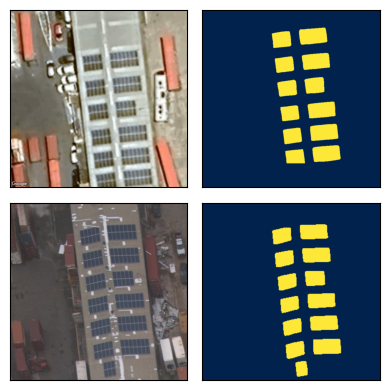

./panel_segmentation/examples/puerto_rico_pre_hurricane_images\20170923aC0643730w174630n_17.755921683652495_-64.61565564054749.png


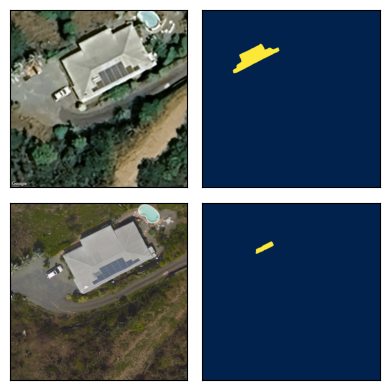

./panel_segmentation/examples/puerto_rico_pre_hurricane_images\20170923bC0644630w174630n_17.753614194913194_-64.76843834010256.png


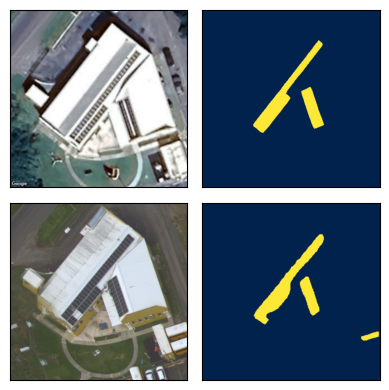

./panel_segmentation/examples/puerto_rico_pre_hurricane_images\20170923bC0644630w174630n_17.77098719486288_-64.76338464575298.png


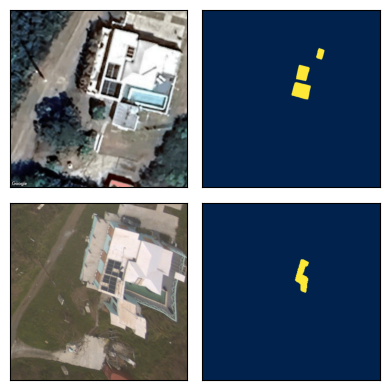

./panel_segmentation/examples/puerto_rico_pre_hurricane_images\20170923bC0644800w174630n_17.752847839809693_-64.77722415663133.png


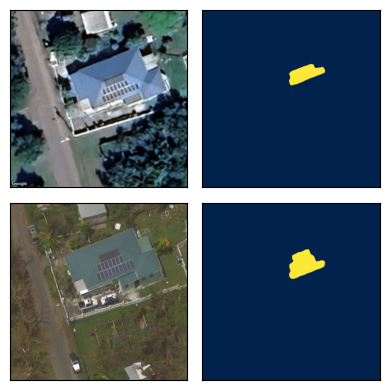

./panel_segmentation/examples/puerto_rico_pre_hurricane_images\20170924aC0654800w180900n_18.130325377062075_-65.78995277940152.png


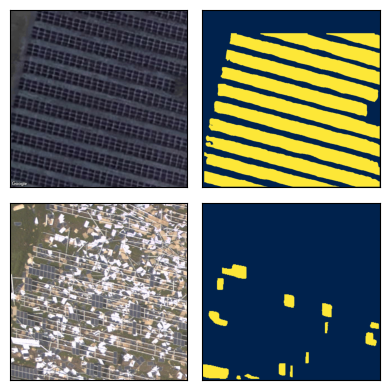

In [35]:
for image in example_pre_hurricane_images:
    pre_img = mmcv.imread(image, channel_order='rgb')
    pre_result = inference_detector(pre_model, pre_img)
    pre_predictions = pre_result._pred_instances
    pre_masks, pre_labels, pre_scores = pre_predictions.masks, pre_predictions.labels, pre_predictions.scores
    # Cutoff any of the scores under threshold
    idx_to_keep = np.argwhere(pre_scores>=0.5).tolist()[0]
    pre_masks, pre_labels = pre_masks[idx_to_keep], pre_labels[idx_to_keep]
    # Run inference on the corresponding post-storm image
    destruction_img = os.path.join("./panel_segmentation/examples/puerto_rico_post_hurricane_images", os.path.basename(image))
    post_img = mmcv.imread(destruction_img, channel_order='rgb')
    post_result = inference_detector(post_model,  post_img)
    post_predictions = post_result._pred_instances
    post_masks, post_labels, post_scores= post_predictions.masks, post_predictions.labels, post_predictions.scores
    idx_to_keep = np.argwhere(post_scores>=0.5).tolist()[0]
    post_masks, post_labels = post_masks[idx_to_keep], post_labels[idx_to_keep]
    # Convert mask to image
    # Pre-storm mask
    pre_anns_img = mask_to_np(pre_img, pre_masks, pre_labels)
    post_anns_img = mask_to_np(post_img, post_masks, post_labels)
    # Post-correction in case pre- and post- images are not the same size
    post_anns_img = cv2.resize(post_anns_img, dsize=(pre_img.shape[0], pre_img.shape[1]), 
                                interpolation=cv2.INTER_CUBIC)
    # Perform 2-D cross-correlation on the pre-storm mask to align it with the post-storm mask (via FFT)
    cross_corr = signal.correlate(post_anns_img, pre_anns_img, mode='same', method='fft')
    # Shift the image based on highest cross-correlation value
    new_center = np.unravel_index(cross_corr.argmax(), cross_corr.shape)
    translation_x, translation_y = new_center[1]-pre_anns_img.shape[0]/2, new_center[0]-pre_anns_img.shape[1]/2
    pre_anns_img = shift(pre_anns_img, [translation_y, translation_x], cval=0)
    pre_anns_img = np.round(pre_anns_img[:pre_anns_img.shape[0], :pre_anns_img.shape[1]])
    # Convert to tensor to run Image Registration
    pre_anns_tensor = torch.from_numpy(np.array(pre_anns_img.reshape(1,1,pre_anns_img.shape[0], pre_anns_img.shape[1])).astype(np.float32))
    post_anns_tensor = torch.from_numpy(np.array(post_anns_img.reshape(1,1,post_anns_img.shape[0], post_anns_img.shape[1])).astype(np.float32))
    # Registration against the two masks
    registrator = ImageRegistrator('similarity',
                                    tolerance=.001, loss_fn=F.mse_loss)
    model = registrator.register(pre_anns_tensor, post_anns_tensor)
    aligned_mask = registrator.warp_src_into_dst(pre_anns_tensor)
    # Align the image as well
    aligned_no_damage_img = registrator.warp_src_into_dst(pre_anns_tensor)
    # Plot results
    print(image)
    fig, axs = plt.subplots(2, 2, figsize=(4,4))
    axs = axs.flatten()
    axs[0].imshow(pre_img)
    axs[1].imshow(
            np.round(kornia.tensor_to_image(aligned_mask[0].sum(dim=0, keepdim=True))),
            cmap=plt.get_cmap('cividis'),
        )
    axs[2].imshow(post_img)
    axs[3].imshow(
            np.round(kornia.tensor_to_image(post_anns_tensor[0].sum(dim=0, keepdim=True))),
            cmap=plt.get_cmap('cividis'),
        )
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    fig.tight_layout()
    plt.show()
    plt.close()        